In [17]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from tqdm import trange
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000) 

In [18]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [19]:
path = '/Users/charlie/ML/Stocks/Data/processed_tqqq_trades.csv'
df = pd.read_csv(path)
df.head()

,Num Of Trading Min,LastBuyScore,Position Num of Buys,Position Current Price Real,Position Current Price 10 Min avg,Security Trade Signal,Security Trade Signal Reason,Security Trade Score,Opp Security,Opp Security Trade Score,BuyReason,Open Price,Previous Closing Price,Short MAVG 5,Long MAVG 13,Short MAVG Min,Long MAVG Min,MAVG Min Diff,ATR Stoploss Range,ATR Stoploss,Slope 15 Min,Slope 15 Min Win Diff,RSI,Previous Day RSI,RSI Slope,RSI Gain Percent,Last AB Pattern,Last AB Age,Last AB Stop-Loss Level,Last AB Total Net,Last AB Net Age Ratio,Last Confirmed Signal,Last Confirmed AB Confirmation Level,Last Confirmed AB Age,Last Confirmed AB Total Net,Position Last Buy DT,Position Day Slope High,Daily Current Gain Loss Percent,Daily Max Gain Percent,Daily Max Gain Loss Ratio,Daily Max Loss Percent,Daily Max Loss Ratio,Daily Current Gain Loss Percent From Open,Daily Max Gain Percent From Open,Daily Max Gain Loss Ratio From Open,Daily Current Gain Loss Diff From Open Close,Position Last Sell DT,Position Num of Days Since Last Sell,Opp Pos Num of Days Since Last Buy,Opp Pos Num of Days Since Last Sell
0,307,-0.752129,1,66.780,66.8420,0,6,-5.967799,0,5.209109,6,66.550,66.885,67.7810,67.788846,66.569300,66.613600,-0.044300,1.996510,64.553490,36.402546,47.722228,38.866392,44.794960,-5.928568,-13.234900,11,1,66.120,3,3.0,0,68.460,5,8,0,0.0,-0.156986,0.710174,0.615835,-1.517530,2.064667,0.343874,0.710174,0.260137,0.500860,0,4.0,0,0
1,53,-0.827437,1,65.115,64.9925,0,6,-2.304925,0,-1.995048,6,63.870,64.940,66.7170,67.498077,64.719567,64.575383,0.144183,2.097237,61.772763,26.725338,-1.979978,28.503168,26.902708,1.600460,5.949065,11,2,66.120,3,1.5,2,65.750,1,3,1,0.0,0.269480,0.608254,0.206061,-1.870958,4.004668,1.917154,0.608254,-0.796144,1.647675,1,1.0,1,1
2,93,-0.890121,2,65.555,65.4275,0,6,3.168636,0,-3.562561,6,63.870,64.940,66.7170,67.498077,64.914500,64.918050,-0.003550,2.097237,61.772763,40.653666,39.561330,33.976728,26.902708,7.074020,26.294826,11,2,66.120,3,1.5,2,65.750,1,3,2,0.0,0.947028,1.053280,0.111913,-1.870958,5.272333,2.594703,1.053280,-1.623550,1.647675,2,0.0,1,1
3,23,1.049423,1,67.205,67.0900,0,6,4.192252,0,-4.907624,6,66.475,65.865,66.5430,67.513077,66.509600,66.343383,0.166217,2.119445,64.355555,25.999220,-15.740310,46.398256,37.355620,9.042637,24.206897,26,1,63.725,8,8.0,2,65.750,2,3,3,0.0,2.034464,2.148334,0.244629,0.645259,-0.896397,1.108328,2.148334,2.234280,-0.926137,3,1.0,2,2
4,21,2.056933,1,69.405,69.4000,0,4,8.306845,0,-9.292201,4,68.515,67.900,66.8808,67.708385,68.836733,68.394967,0.441767,2.142778,66.372222,26.767875,-33.572576,64.257315,51.812547,12.444768,24.018831,26,2,63.725,8,4.0,0,66.838,3,8,4,0.0,2.216495,2.334315,0.275030,0.883652,-1.177769,1.310751,2.334315,2.389321,-0.905744,4,1.0,3,3


In [20]:
train_size = int(len(df) * 0.9)
train = df.head(train_size)
test = df.tail(len(df) - train_size)

In [21]:
seq_length = 20
train_length = 224
input_dim = 49
hidden_dim = 32
num_layers = 8
output_dim = 1
num_epochs = 1000

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out

In [23]:
def sliding_windows(X, Y, seq_length):
    x = []
    y = []

    for i in range(len(X)-seq_length-1):
        _x = X[i:(i+seq_length)]
        _y = Y[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [24]:
def train(trainX, trainY, testX):
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    # criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    criterion = torch.nn.MSELoss(reduction='mean')
    # optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss_plot = np.array([])
    for epoch in range(num_epochs):
        model.train()
        y = model(trainX.to(device)).flatten()
        loss = criterion(y, trainY)
        train_loss_plot = np.append(train_loss_plot, loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    model = model.eval()
    with torch.no_grad():
        y = model(testX)
    return train_loss_plot, y

In [25]:
def get_data(df, pos, seq_length, train_length):
    trainx = df.drop(columns=['Open Price'])[pos-train_length:pos]
    trainy = df['Open Price'][pos-train_length+1:pos+1]
    trainx, trainy = sliding_windows(trainx.to_numpy(), trainy.to_numpy(), seq_length)
    trainx = Variable(torch.Tensor(np.array(trainx))).to(device)
    trainy = Variable(torch.Tensor(np.array(trainy))).to(device)
    
    testx = df.drop(columns=['Open Price'])[pos-seq_length+1:pos+1]
    testy = df['Open Price'][pos+2]
    testx = Variable(torch.Tensor(np.array(testx))).to(device)
    testy = Variable(torch.Tensor(np.array(testy))).to(device)
    return trainx, trainy, testx, testy

In [26]:
predicted = np.array([])
test = np.array([])
for i in trange(train_length, len(df) - 3):
    trainx, trainy, testx, testy = get_data(df, i, seq_length, train_length)
    testx = testx.reshape(1, 20, input_dim)
    train_loss_plot, y = train(trainx, trainy, testx)
    test = np.append(test, testy)
    predicted = np.append(predicted, y) 

100%|██████████| 121/121 [1:48:52<00:00, 53.98s/it]


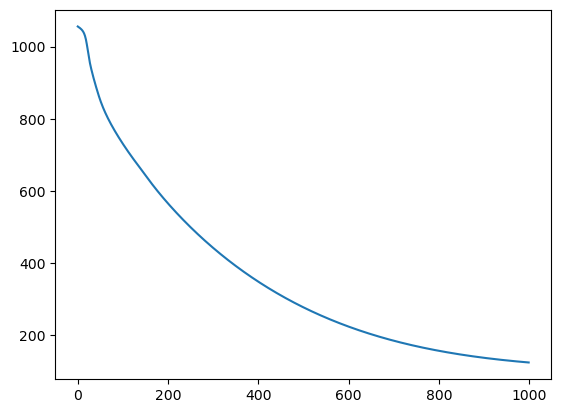

In [27]:
plt.plot(train_loss_plot)

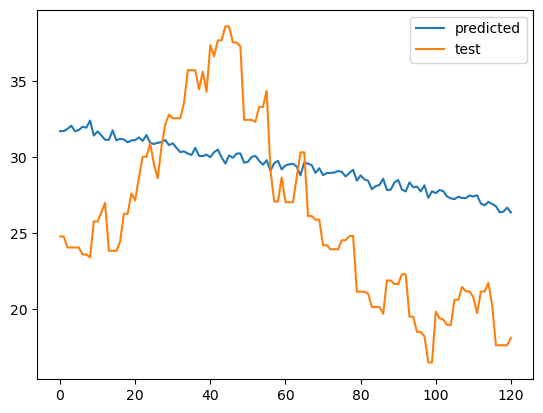

In [28]:
plt.plot(predicted)
plt.plot(test)

plt.legend(['predicted', 'test'])

In [29]:
mean_squared_error(predicted, test)

37.6670436275275

In [30]:
t = np.array()

TypeError: array() missing required argument 'object' (pos 0)

In [31]:
mean_squared_error(test.mean(), test)

TypeError: Singleton array 26.06452888299611 cannot be considered a valid collection.

In [ ]:
test.mean()

26.06452888299611